In [30]:
# STEP 1
# preparing feedback data paths over time for GP practices

import pandas as pd
import numpy as np
import os
import iisignature
import time
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import math
from datetime import date

def month(csv_file):
    """
    Adds column with month values for each review date.
    """
    df = pd.read_csv(csv_file)
    if 'month' in list(df):
        print("'month' column was already in the '" + csv_file + "' file")
    else:
        ll = df['datetime'].values.tolist()
        ll = [date.fromordinal(x).month for x in ll]
        df['month'] = ll
        df.to_csv(csv_file, index=False)
        print("'month' column added to the '" + csv_file + "' file")
        

def make_paths(csv_file, min_day=None, max_day=None, depvar= "q9", ignore_nan = True):
    """
    
    Makes paths from panel data. Paths can be used to compute signatures and log signatures
    
    make_paths returns a dictionary with paths of records over time for each data point
    (e.g. a data point is feedback about a GP practice over time)
    
    inputs:
        - "csv_file" (str): name of .csv-formatted file containing topic proportions for each message
        - min_day (int): first cut-off day from which reviews are considered. First day of year 0 AD equals to 1, 
                        second day of that year equals to 2, and so on. Default value is "None" (i.e. all dates 
                        when feedback was posted apply)
        - max_day (int): last cut-off day to which reviews are considered. First day of year 0 AD equals to 1, 
                        second day of that year equals to 2, and so on. Default value is "None" (i.e. all dates 
                        when feedback was posted apply)
        - depvar (str): name of dependent variable to be considered when constructing the paths. Reviews which don't
                        contain this variable will be ignored. If more than one review is posted at a given day (very 
                        low likelihood of this), feedback scores are averaged for the given day.
        - ignore_nan (logical): whether to exclude reviews which have no value for the dependent variable. Reviews with
                        a missing dependent variable are excluded by default
                        NOTE: If reviews with missing dependent variable are to be included in the output of this 
                        function, the make_sigs() function will only run without error if parameter include_depvar 
                        is set to False.
    
    output:
        The function returns a dictionary where each entry corresponds to a GP practice. Dictionary values are lists
        with all feedback that was posted about the GP practice, ordered according to the day of posting. 
        Information about the oldest review comes first, the second oldest second, and so on. 
    
    
    Example:
    
    # A dataset contains feedback about a GP practice with ID number 1000, where reviewers provided 
    # Likert-scale response to question 10, i.e. "Do the staff treat you with dignity and respect?" 
    # Likert-scale responses are the dependent variable.
    
    paths = make_paths("my_demo_data.csv", depvar= "q10.numeric")
    
    # There are two reviews about this GP practice which were posted in days 7000 and 8200
    # In addition, the oldest reviews in "my_demo_data.csv" are from day 6000. 
    
    for review in paths[1000]: #this would print the two reviews about GP practice with ID 1000
        print(review)
    
    # The print() function returns:
    
    [array(7000), array(1.0), array(0.23), array(0.58), array(0.19), array(1.0), array(3.0), array(1000)]
    [array(8200), array(4.0), array(0.73), array(0.13), array(0.14), array(1.0), array(6.0), array(1200)]
    
    # review from day 7000 had Likert-scale response 1 (i.e. 1 our of 5 stars)
    # 23% of it were positive topics, 58% were negative topics, and 19% were neutral topics
    # 1 review was posted on that day, and it was posted in March, 1000 days after the oldest 
    # reviews in "my_demo_data.csv".
    
    # review from day 8200 had Likert-scale response 4 (i.e. 4 our of 5 stars)
    # 73% of it were positive topics, 13% were negative topics, and 14% were neutral topics
    # 1 review was posted on that day, and it was posted in June 1200 days after the last 
    # review of this GP practice


    To do:
        Making this function faster is key to making elastic net computation faster.
    """
    df = pd.read_csv(csv_file)
    
    if depvar in list(df) and depvar[0] == 'q':
        depvar = list(df).index(depvar)
    else:
        print("WARNING: check the column name for your dependent variable. The one you provided doesn't exist")
        return(None)
    
    df = df.values.tolist()
    

    #setting min and max dates if none were provided for either 
    if min_day == None or max_day == None:
        df2 = [x[2] for x in df]
        if min_day == None:
            min_day = min(df2)
        if max_day == None:
            max_day = max(df2)

    sciezki = {}
    stopnie = [list() for x in range(min_day,max_day+1)]
    for i,v in enumerate(df):
        if int(v[2]) >= min_day and v[2] <= max_day:
            if np.isnan(v[depvar]) == True and ignore_nan == True:
                continue
            if v[1] in sciezki:
                d = int(v[2]) - min_day
                temp = [d]
                temp.append(v[depvar])
                temp.append(1)
                temp.extend(v[10:])
                v2 = sciezki[v[1]][:]
                temp = [np.array(float(x)) for x in temp]
                if len(v2[d]) == 0:
                    v2[d] = temp
                    sciezki[v[1]] = v2
                else:
                    temp2 = [v2[d][0]]
                    weight_old = v2[d][2]/(v2[d][2] + 1)
                    weight_new = 1 - weight_old
                    indeksy = list(range(1,len(temp)))
                    for x in indeksy:
                        if x != 2:
                            xx = v2[d][x]*weight_old + temp[x]*weight_new
                            temp2.append(np.array(xx))
                        else:
                            temp2.append(np.array(v2[d][2]+1))
                    v2[d] = temp2
                    sciezki[v[1]] = v2
            else:
                d = int(v[2]) - min_day
                v2 = stopnie[:]
                temp = [d]
                temp.append(v[depvar])
                temp.append(1)
                temp.extend(v[10:])
                v2[d] = [np.array(float(x)) for x in temp]
                sciezki[v[1]] = v2
    
    del df

    # delete empty lists from GP paths. 
    # Add variable informing time distance from last available period
    to_pop = []
    for x in sciezki:
        temp = sciezki[x]
        temp2 = []
        l = 0        
        for i,y in enumerate(temp):
            if len(y) == 0:
                l = l + 1
            else:
                y.append(np.array(l))
                temp2.append(y)
                l = 1

        sciezki[x] = temp2
        if len(temp2) < 2: # paths can only be computed if there are at least 2 records in the path
            to_pop.append(x)
            
    for x in to_pop:
        sciezki.pop(x)
    return sciezki


# month("r_output.csv")
# demo = make_paths('r_output.csv',depvar='q9', min_day=735008)

print('ok')


ok


In [31]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# STEP 2
# calculating data path weights and weighting paths


def datweights(csv_file, depvar, chunkmin = 1000, daymin = 735008, daymax = 736620, window = 60):
    
    """
    Evaluating preditive usefulness of data points in data paths to create weights for each data path. 
    
    Weights are used as a 'confidence scores' with uses in prediction of satisfaction from path signatures. 
    Each data path has its signature computed, and then that signature is multiplied by its weight. 
    Signature weighting is meant to prioritise model training from data signatures 
    where original data are more abundant and recent. It is less important to achieve accurate prediction for
    data paths where there are very few reviews, especially very few reasonably recent reviews.
    
    inputs:
        csv_file (str): name of .csv file with reviews data
        depvar (str): determines which reviews are considered. Only reviews with a chosen response are used for 
                    weighting of data paths
        chunkmin (int): minimum number of reviews included in each chunk of data for which a weight is calculated.
                    Weights are computed for groups of reviews (chunks) starting from oldest reviews. 
                    Each chunks groups no less than minchunk reviews in chronological order of their posting.
                    1000 reviews is the minimum default chunk size.
        daymin (int): earliest day from which reviews are considered. 735008 (20th May 2013) is the earliest date
                    considered by default.
        daymax (int): last date from which reviews are considered. 736620 (18th October 2017) is the last date
                    considered by default.
        window (int): number of days from which reviews are compared to chunks, counting from the most recent day. 
                    Last 60 days are the default.
        
    outputs:
        w_daily (list of lists): each list in w_daily provides a daily time stamp and the weight
                    of any feedback posted on any given day.
        params (list): parameters used for weights training:
                    depvar, daymin, daymax, window
    
    """
    params = [csv_file, depvar, daymin, daymax, window]

    daymax = daymax + 1
#     w = [] # list for storing data path weights.
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=[depvar]) # drop rows with missing 'depvar'
    # compute chunk cut-off date ranges. Chunks are part-overlapping so that each review 
    
    daty = df['datetime'].values.tolist()
    nr = 0
    chunks = []
    chunk = [0,daymin-1]
    
    #chunks created starting from the oldest reviews being used
    for d in daty:
        if d >= daymin and d < daymax - window:
            if nr < chunkmin:
                if chunk[1] == d:
                    nr = 0
                else:
                    nr = 1 + nr
            else:
                nr = 0
                chunk[0] = chunk[1] + 1
                chunk[1] = d
                tmp = chunk[:]
                chunks.append(tmp)
    if daymax - window - 1 > chunk[1] + 1:
        chunks.append([chunk[1] + 1, daymax - window - 1])
    else:
        chunks[-1] = [chunks[-1][0], daymax - window - 1]

    #chunks created starting from most recent reviews being used
    chunk = [daymax - window,daymax - window - 1]
    nr = 0
    daty = list(reversed(daty))
    for d in daty:
        if d < daymax - window and d >= daymin:
            if nr < chunkmin:
                if chunk[1] < d:
                    pass
                else:
                    nr = 1 + nr
            else:
                nr = 0
                chunk[0] = d
                tmp = chunk[:]
                chunks.append(tmp)
                chunk[1] = d - 1
    if chunk[0] - 1 > daymin:
        chunks.append([daymin, chunk[0] - 1])
    else:
        chunks[-1] = [daymin,chunks[-1][1]]

#     form corpus of reviews from 'window'. Extracting dependent variable values
    test = df.loc[df['datetime'].isin(list(range(daymax - window,daymax)))]
    test = test.loc[:,['nhs_gp_num',depvar]]
    test = test.groupby(['nhs_gp_num']).mean()
    test.rename(columns={depvar: 'depvar_test_window'}, inplace=True)
    test['nhs_gp_num'] = test.index

    # calculate predictive value for reviews in each chunk. 4 small steps here:
    # 1) linear regressions predicting next "window" days
    # 2) used train lr model to predict last 'window' days from data period
    # 3) calculate R2 for prediction using formula: 1 - (sum of squared errors)/(total sum of squares)
    # 4) give 0 where R2 < 0 (i.e. where model performs worse than prediction with mean of last 'window' days)
    
    # 1) linear regressions predicting next "window" days
    tmp = list(df)[1:-1]
    cols = []
    for col in tmp:
        if col[0] == 'q' and col != depvar:
            pass
        else:
            cols.append(col)
    del cols[cols.index('content')]
    df = df.loc[:,cols]
    tmp = []
    for ch in chunks:
        tmp.append(int(''.join([str(x) for x in ch])))
    tmp = list(set(tmp)) # removing duplicate periods from 'chunks' - to speed up computation of weights
    tmp = sorted(tmp)
    tmp = [str(x) for x in tmp]
    chunks = [[int(x[:6]),int(x[6:])] for x in tmp] 
    for chunk in chunks:
#         if chunks.index(chunk) < 100:
        data = df.loc[df['datetime'].isin(list(range(chunk[0],chunk[1] + 1)))]
        data.pop('datetime')
        data.rename(columns={depvar: 'depvar_as_predictor'}, inplace=True)
        target = df.loc[df['datetime'].isin(list(range(chunk[1] + 1,chunk[1] + 1 + window)))]
        target = target.loc[:,['nhs_gp_num',depvar]]
        target = target.groupby(['nhs_gp_num']).mean() # average target values for each GP id
        target['nhs_gp_num'] = target.index           
        ckdf = pd.merge(data, target, how='inner', on='nhs_gp_num', sort=False)
        reg = linear_model.LinearRegression()
        reg.fit(ckdf[list(ckdf)[1:-1]], ckdf[depvar])
# 2) used train lr model to predict last 'window' days from data period
        ckdf = pd.merge(ckdf, test, how='inner', on='nhs_gp_num', sort=False)
        res = reg.predict(ckdf[list(ckdf)[1:-2]])
        ckdf['res'] = res
# 3) calculate R2 for prediction using formula: 1 - (sum of squared errors)/(total sum of squares)
        r2 = r2_score(ckdf['depvar_test_window'],ckdf['res'])
# 4) give 0 where R2 < 0 (i.e. where model performs worse than prediction with mean of last 'window' days)
        if r2 <= 0:
             chunk.append(0)
        else:
            chunk.append(r2)
    
    # weight for each day stamp (average weight, if more than 1 is available)
    daily = {}
    for ch in chunks:
#         if chunks.index(ch) < 100:
        tmp = list(range(ch[0],ch[1]+1))
        for x in tmp:
            if x in daily:
                daily[x].append(ch[2])
            else:
                daily[x] = [ch[2]]
    days = list(range(daymin, daymax))
    w_daily = []
    for d in days:
        if d in daily.keys():
            w_daily.append([d,np.mean(daily[d])])
        elif d >= daymax - window:
            pass
        else:
            print('Day ' + str(d) + " has no calculated weight")
    
    return(w_daily, params)



def pathweights1run(datw):
    """
    Calculates data path weights from a single run of datweights() function.
    
    
    The weights are calculated using the weight data from datweights() function, which is provided as one of the inputs
    to this function. 
    
    Inputs:
        datw (list): object produced with function datweights()
        
    Outputs:
        wg (dict): dictionary of data path weights
        params (list): parameters used to compute data path weights
    
    """
    
    params = datw[1]
    df = pd.read_csv(datw[1][0])
    df = df.dropna(subset=[datw[1][1]])
    
    dat = [x[0] for x in datw[0]]
    w = [x[1] for x in datw[0]]
    wag = pd.DataFrame()
    wag['datetime'] = dat
    wag['weight'] = w
    wg = pd.merge(df, wag, how='inner', on='datetime', sort=False)
    wg = wg[['nhs_gp_num','weight']].groupby(['nhs_gp_num']).sum()

    res = [wg,params]
    return res




# ressies = datweights("r_output.csv", 'q9', chunkmin = 5000,
#                     daymin = 735008, daymax = 736620, window = 60)

# sigw = pathweights1run(ressies)

print('ok')

ok


In [32]:
# comparing different sets of weights

def avg_datweights(csv_file, depvar, daymin = 735008, daymax = 736620, chunkmin = 5000, window = 60, start = 735320, step = 20):

    """
    
    Calculates average data point weights based on a series of runs of datweights() function.
    
    
    The weights of datapoints represent average predictive value of a review according to when reviews were posted
    relative to star ratings being predicted in the dependent variable period. 
    
    Inputs:
        csv_file (str): name of .csv file with reviews data
        depvar (str): determines which reviews are considered. Only reviews with a chosen response are used for 
                    weighting of data paths. Column names and corresponding survey statements:
                    'q9' - Are you able to get through to the surgery by telephone?
                    'q10' - Are you able to get an appointment when you want one?
                    'q11' - Do the staff treat you with dignity and respect?
                    'q12' - Does the surgery involve you in decisions about your care and treatment?
                    'q13' - How likely are you to recommend this GP surgery to friends and family if they needed similar care or treatment?
                    'q14' - This GP practice provides accurate and up to date information on services and opening hours
        daymin (int): earliest day from which reviews are considered. 735008 (20th May 2013) is the earliest date
                    considered by default.
        daymax (int): last date from which reviews are considered. 736620 (18th October 2017) is the last date
                    considered by default.
        chunkmin (int): minimum number of reviews included in each chunk of data for which a weight is calculated.
                    Weights are computed for groups of reviews (chunks) starting from oldest reviews. 
                    Each chunks groups no less than minchunk reviews in chronological order of their posting.
                    5000 reviews is the default minimum chunk size.
        window (int): number of days from which reviews are as dependent variables and compared to chunks. 
                    Last 60 days are the default window length. 'window' number of days are obtained at every 'step' 
                    days. The earliest 'window' of days ends at the 'start' date. The latest 'window' ends at the 
                    'daymax' date. For example, if daymin = 1, daymax = 600, start = 300, step = 50 and window = 100,
                    the test period windows would take periods [201-300], [251-350], [301-400], [351-450] and [401,500].
                    According to different 'window' periods of days, reviews are grouped into chunks and the predictive 
                    value of each chunk of reviews is computed with datweights() function. In this example, the chunks 
                    would be produced by grouping, respectively, reviews posted on days [1-200], [1-250], [1-300], [1-350] 
                    and [1-400]. This arrangement means that composition of chunks is not the same for each run of datweights()
                    function.
        start (int): earliest cut-off date up to which a 'window' period of days is calculated. It is advised to 
                    make start > daymin + window. Setting a start date too early may mean that only 1 chunk of reviews 
                    can be produced, and that there may be fewer than 'minchunk' number of available reviews in that
                    period (making the usefulness of the prediction from such a group of reviews less useful than predictions
                    made with other chunks which are similar in size. Default start = 735320
        step (int): Time gap between the beginnings and ends of 'window' periods. In default, step = 20.
        
    Outputs:
        wg (dict): dictionary of data path weights
        params (list): parameters used to compute data path weights, which are then useful for computation of path weights
    
    
    Example:
    To predict average star
    rating during last 60 days of feedback in response to the question (depvar = 'q9)
    the first value output
    with avg_datweights() function corresponds to any review
    
    """
    
    params = [csv_file, depvar, daymin, daymax, window]
    
    daymax = daymax+1

    lastdays = list(range(start, daymax, step))
    weights = {}
    for ld in lastdays:
        res = datweights(csv_file, depvar, daymin = daymin, daymax = ld, chunkmin = chunkmin, window = window)
        res = [x[1] for x in res[0]]
        weights[ld] = res

    avgs = list(np.zeros(daymax-daymin-window))
    licznik = list(np.zeros(daymax-daymin-window))
    for wl in weights.keys():
        tmp = list(range(len(weights[wl])))[::-1]
        w2 = [weights[wl][x] for x in tmp]
        for i, w in enumerate(w2):
            avgs[i] = avgs[i] + w
            licznik[i] = licznik[i] + 1

    ws = [] # final weights
    for x in list(range(len(licznik))):
        ws.append(float(avgs[x])/float(licznik[x]))
    res = [ws, params]
    return res



# wagi = avg_datweights("r_output_demo.csv", 'q9', step = 20)

# # plotting average daily weights
# plt.plot(wagi[0])
# plt.title("Review weights according to time lag")
# plt.ylabel('weight (R2)')
# plt.xlabel('days away')
# plt.show()

def path_weights (ad):
    """
    Computes path weights based on outputs of avg_datweights() function
    
    Sums weights of reviews constituting each data path
    
    Inputs:
        ad (list): output of avg_datweights() function. The relevant parameters of avg_datweights() are copied
                    and used to run this function.
    
    Output:
        res (pandas.DataFrame): weight of GP feedback paths
    
    """
    
    df = pd.read_csv(ad[1][0])
    df = df.dropna(subset=[ad[1][1]]) # drop rows with missing 'depvar'
    df = df[['nhs_gp_num','datetime']]
    
    tmp = list(range(ad[1][2],ad[1][3]-ad[1][4]+1)) # list of dates for which corresponding weights are available
    dftmp = pd.DataFrame()
    dftmp['datetime'] = tmp[::-1]
    dftmp['weight'] = ad[0]
    bound = pd.merge(df, dftmp, how='inner', on='datetime', sort=False)
    bound = bound.sort_values(by=['nhs_gp_num', 'datetime'])

    pw = bound.groupby(['nhs_gp_num']).sum()
    pw = pw.drop(['datetime'], axis=1)
    pw['nhs_gp_num'] = pw.index
#     pw = pw.transpose().to_dict('list')
    
    return(pw, bound)
    
    
# ddff = path_weights(wagi)


print("ok")

ok


In [33]:
#STEP 3

def make_sigs(dataset, degs, file_out, log=False, sample=None,include_depvar=False):
    """
    Function for:
    1. Obtaining signatures from pre-processed data
    2. Saving output with a specified file name
    
    Inputs:
        - dataset (dictionary): paths to transform with signatures
        - degs (int): degrees of the signature to be obtained
        - file_out (str): name of a .csv file where signatures are saved
        - log (logical): whether to compute log signatures (default is "False", i.e. to compute a plain signature)
        - sample(int): number of signatures to compute (default is "None", i.e. signatures are
                obtained for all data paths)
        - include_depvar (logical): whether to include past Likert-scale responses as independent variables for 
                prediction of the dependent variable
    
    Outputs:
        - file in .csv format containing signatures of paths processed with the function. List of predictors:
            - TUTAJ WYMIENIAM CO POSŁUŻYŁO DO UTWORZENIA SYGNATUR
    
    """

    if sample == None:
        sample = len(dataset)
    przyg = 0
    if log == True:
        if include_depvar == True:
            przyg = len(dataset[sorted(list(dataset))[0]][0]) #counting data dimensions to be converted into signatures
        else:
            przyg = len(dataset[sorted(list(dataset))[0]][0]) - 1 #counting data dimensions to be converted into signatures
        przyg = iisignature.prepare(przyg,degs)
    
    # compute signatures (also need a signature of the depvar)
    signatures = []
    if type(dataset) == dict:
        counter = 0
        for x in sorted(list(dataset)):
            if counter < sample:
                s = []
                for xx in dataset[x]:
                    tm = [xx[0]]
                    if include_depvar == True:
                        tm.append(xx[1])
                    tm.extend(xx[2:])
                    s.append(tm)
                if log == False:
                    s = iisignature.sig(s,degs) # ADD OPTION FOR LOGSIG
                else:
                    s = iisignature.logsig(s,przyg)
                s = list(s)
                s.insert(0,x)
                signatures.append(s)
                counter = counter + 1
    else:
        print("WARNING: something is not right with the data type of your paths. The make_sigs() function is meant for processing paths in a dictionary format produced with the make_paths() function")
    
    
    #length of header must match length of rows for this code to work without error
    header = list(range(1,len(signatures[0])))
    header.insert(0,'practice_id')
    signatures = pd.DataFrame(signatures)
    
    signatures.to_csv(file_out, index=False, header = header) # in the future, one can label signature dimensions with values of the iteratege integral
    
    return(signatures)


def make_depvar (csv_file, depvar, day):
    """
    
    generates dependent variable dataset for specified set of days 
    
    inputs:
        - "csv_file" (str): name of .csv-formatted file containing dependent variable data
        - depvar (str): name of dependent variable for which to retrieve datapoints.
        - day (int or list): day or days for which to collect the dependent variable data. If more than one
                value is available for a GP practice on a given day or set of days, values are averaged.
        
    Output:
        A list of GP IDs with corresponding dependent variable values, where dependent variable data are available.
    
    """

    
    df = pd.read_csv(csv_file)

    if depvar in list(df) and depvar[0] == 'q':
        depvar = list(df).index(depvar)
        
    df = df.values.tolist()
    
    dep_list = []
    for row in df:
        if type(day) == int:
            if row[2] == day and np.isnan(row[depvar]) == False:
                dep_list.append([row[1],row[depvar]])
        elif type(day) == list:
            if row[2] in day and np.isnan(row[depvar]) == False:
                dep_list.append([row[1],row[depvar]])
    
    gp_dict = {}
    for item in dep_list:
        if item[0] in gp_dict:
            tmp = gp_dict[item[0]]
            gp_dict[item[0]] = [tmp[0]+item[1],tmp[1]+1]
        else:
            gp_dict[item[0]] = [item[1],1]

    dep_list = []
    for gp in sorted(gp_dict.keys()):
        tmp = gp_dict[gp]
        x = tmp[0]/tmp[1]
        dep_list.append([gp,x])
    
    return(dep_list)

print("ok")

ok


In [36]:
#STEP 4
# predicting level of patient satisfaction based on signatures of feedback from the past

def elnet_weighted(csv_file, depvar='q9', ignore_nan=True, sig_min_day=735008, test=[736621, 736680], folds=5, 
                   seed=1,log=False,degs=2,sample=None,sigs_with_depvar=False, chunkmin = 5000, start = 735320, 
                   step = 20):
    """
    
    Runs elastic net model with cross-validation 
    (weighed data paths enabled)
    
    
    inputs:
        - "csv_file" (str): name of .csv-formatted file containing topic proportions for each message
        - depvar (str): name of dependent variable to be considered when constructing the paths. Reviews which don't
                        contain this variable will be ignored. If more than one review is posted at a given day (very 
                        low likelihood of this), feedback scores are averaged for the given day.
        - ignore_nan (logical): whether to exclude reviews which have no value for the dependent variable. Reviews with
                        a missing dependent variable are excluded by default
                        NOTE: If reviews with missing dependent variable are to be included in the output of this 
                        function, the make_sigs() function will only run without error if parameter include_depvar 
                        is set to False.
        - min_day (int): first cut-off day from which reviews are considered for construction of signatures. First 
                        day of year 0 AD equals to 1, second day of that year equals to 2, and so on. 
                        In the dataset used here, day 735008 (the default value) is the first day for which more 
                        feedback is available. You can also set min_day = None, which means that even the earliest 
                        available feedback will be used for signatures.
        - max_day (int): last cut-off day for which reviews are considered for making signatures. First day of 
                        year 0 AD equals to 1, second day of that year equals to 2, and so on. Default value is 736678.
        - mtrain_pred_day (int): The day from which dependent variable data are used for model training. It should be
                        a value between 735008 and 736780 if the example dataset is used. Default value is 736679.
        - mtest_pred_day (int): The day from which dependent variable data are used for model testingIt should be
                        a value between 735008 and 736780 if the example dataset is used. Default value is 736680.
        - folds (int): number of folds used for elastic net cross-validation. The default is 5
        - seed (int): number selecting quasi random choice of data points for train and test sets in elastic net
          cross-validation. 'seed = None' means that each Lasso cross-validation will take in different
          choices of training and test sets of data points. The default value is 1
        - log (logical): Defaults to false
        - degs (int): number of degrees used for computation of a (log)signatures. The default is 2
        - sample (int): =None
        - sigs_with_depvar (logical): =False
    
#     output:
#         - trained elastic net model according to set model parameters
#         - elastic net cross-validation outcomes for test and train datasets
    
#     Example:
    
    
#     To do:
#     - Add possibility for mtrain_pred_day and mtest_pred_day to take in lists of days. That may be used to increase 
#     the number of datapoints available for model training and testing
#     """
    
    window = max(test) - min(test) + 1
    
    # checking the validity of model parameters
    if ignore_nan == False and sigs_with_depvar == True:
        print("""WARNING: you can't run this function with parameters ignore_nan = False, and sigs_with_depvar = True. 
                This would mean you want to construct signatures from paths which have missing data.
              """)
        return(None)
    elif sigs_with_depvar == True:
        if sig_min_day in list(range(min(test)-window,max(test))):
            print("""WARNING: Your 'sig_min_day' parameter doesn't allow to compute prediction.
            It needs to be an early enough date to make model training/testing possible.
            """)
            return(None)
    

    train_sig_max = 2*min(test) - max(test) - 2
    
    # prepare independent variable data for model training and testing
    x_train = make_paths(csv_file, min_day=sig_min_day, max_day=train_sig_max, depvar= depvar, ignore_nan = ignore_nan)
    x_train = make_sigs(x_train, degs, 'sigs_xtrain.csv', log=log, sample=sample,include_depvar=sigs_with_depvar)
    
    sigmaxday_test = min(test) - 1
    sigminday_test = sig_min_day + window
    x_test = make_paths(csv_file, min_day=sigminday_test, max_day=sigmaxday_test, depvar= depvar, ignore_nan = ignore_nan)
    x_test = make_sigs(x_test, degs, 'sigs_xtest.csv', log=log, sample=sample,include_depvar=sigs_with_depvar)

    # prepare dependent variable data
    y_train = make_depvar(csv_file,depvar, list(range(train_sig_max+1,min(test))))
    y_test = make_depvar(csv_file,depvar, list(range(min(test),max(test)+1)))
    

    # weights calculation
    train_weights = avg_datweights(csv_file, depvar, daymin = sig_min_day, daymax = min(test)-1, 
                                    chunkmin = chunkmin, start = start, step = step, 
                                    window = len(range(min(test),max(test))) + 1)
    train_weights = path_weights(train_weights)
    
    y_train = pd.DataFrame(y_train)
    y_tmp = [str(x) for x in list(y_train.columns)]
    x_tmp = [str(x) for x in list(x_train.columns)]
    y_train.columns = y_tmp
    x_train.columns = x_tmp
    
    joined = pd.merge(left=y_train,right=x_train, left_on='0', right_on='0', how='inner')
    c1 = len(joined.index)
    joined.to_csv('j1.csv', index=False)
    
    joined = pd.merge(left=joined,right=train_weights[0], left_on='0', right_on='nhs_gp_num', how='inner')
    if c1 != len(joined.index):
        print("UWAGA: Coś się nie zgadza w funkcjach avg_datweights(), path_weights() i/lub elnet_weighted()")
        return None

    joined.to_csv('j2.csv', index=False)
    joined = joined.drop(['0'], axis=1)
    y_train_unproc = np.array(joined['1_x'].values.tolist())
    joined[list(joined)[:-2]] = joined[list(joined)[:-2]].multiply(joined["weight"], axis="index")
    joined = joined.rename(columns={'1_x': 'depvar', '1_y': '1'})
    cols = list(joined)
    cols.insert(0, cols.pop(cols.index('nhs_gp_num')))
    cols.insert(1, cols.pop(cols.index('weight')))

    y_train = np.array(joined['depvar'].values.tolist())
    x_train = np.array(joined[joined.columns[3:]].values.tolist())
    
    # the elastic net model with cross-validation
    regr = ElasticNetCV(cv=folds, random_state=seed)
    elnet_ready = regr.fit(x_train, y_train)

    
    # prepare y_test and x_test
    y_test = pd.DataFrame(y_test)
    y_tmp = [str(x) for x in list(y_test.columns)]
    x_tmp = [str(x) for x in list(x_test.columns)]
    y_test.columns = y_tmp
    x_test.columns = x_tmp
    
    joined = pd.merge(left=y_test,right=x_test, left_on='0', right_on='0', how='inner')
    
    y_test = np.array(joined['1_x'].values.tolist())
    x_test = np.array(joined[joined.columns[2:]].values.tolist())
    
    #train and test prediction outcomes
    yhat_train = elnet_ready.predict(x_train) #x_train
    yhat_test = elnet_ready.predict(x_test) #x_test

    window = len(range(min(test),max(test))) + 1
    test_weights = avg_datweights(csv_file, depvar, daymin = sig_min_day + window, daymax = test[1], 
                                    chunkmin = chunkmin, start = start + window, step = step, 
                                    window = window)
    test_weights = path_weights(test_weights)
    
    
    object_to_return = [elnet_ready, y_train, yhat_train, y_test, 
                        yhat_test, test_weights, y_train_unproc]
    return object_to_return




# results = elnet_weighted('r_output.csv', depvar='q9', ignore_nan=True, sig_min_day=735008, 
#                 test=[736621, 736680], folds=5, seed=1,log=False,degs=2,
#                 sample=None, sigs_with_depvar=True, chunkmin = 5000, start = 735320, step = 20)



print('ok')

c:\users\user\envs\radek1\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
c:\users\user\envs\radek1\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


ok


In [37]:
# # MSE ERROR

# # "train error"
# print(mean_squared_error(results[1],results[2]))

# # "test error"
# print(mean_squared_error(results[3],results[4]))

# # "dummy test error"
# dummy = [np.mean(results[1])]*len(results[3])
# print(mean_squared_error(results[3],dummy))

1.55380838934
10.4734593108
2.71807834155


Fitted satisfaction vs actual satisfaction for training variable (reweighed actual satisfaction values)


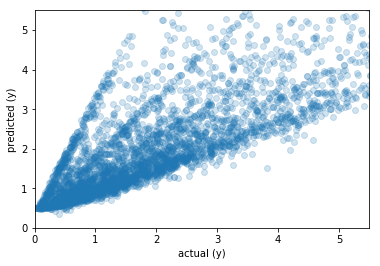

Fitted satisfaction vs actual satisfaction for training variable


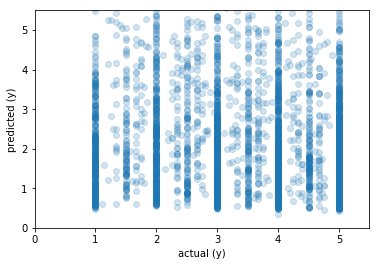

Fitted satisfaction vs actual satisfaction for test variable


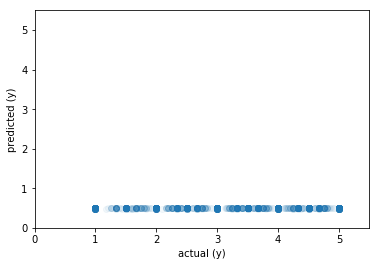

In [38]:
# # print(results[0].coef_)

# print("Fitted satisfaction vs actual satisfaction for training variable (reweighed actual satisfaction values)")
# plt.scatter(results[1], results[2], alpha=0.2) # can be changed into 'test_y' and 'test_yhat'
# plt.xlabel('actual (y)')
# plt.ylabel('predicted (y)')
# axes = plt.gca()
# axes.set_xlim([0,5.5])
# axes.set_ylim([0,5.5])
# plt.show()

# print("Fitted satisfaction vs actual satisfaction for training variable")
# plt.scatter(results[6], results[2], alpha=0.2) # can be changed into 'test_y' and 'test_yhat'
# plt.xlabel('actual (y)')
# plt.ylabel('predicted (y)')
# axes = plt.gca()
# axes.set_xlim([0,5.5])
# axes.set_ylim([0,5.5])
# plt.show()

# print("Fitted satisfaction vs actual satisfaction for test variable")
# plt.scatter(results[3], results[4], alpha=0.05) # can be changed into 'test_y' and 'test_yhat'
# plt.xlabel('actual (y)')
# plt.ylabel('predicted (y)')
# axes = plt.gca()
# axes.set_xlim([0,5.5])
# axes.set_ylim([0,5.5])
# plt.show()


In [107]:
# # new weightings scheme + GP-level elastic net modelling

"""

GP-level elastic net prediction (NO SIGNATURES USED)

Computing elastic model separately for each GP practice in the dataset
Weighting scheme using R2 values. Applying prediction to the same set of GP practices as in formula-based
datapoint weighting scheme.

Given data are available up to mid December 2017, models are trained to predict feedback for September 
and October 2017. Model testing takes place for feedback in November and December 2017. Models are trained and
tested for GP practices which:
    - have at least 2 reviews from period preceding September 2017
    - received some feedback in September or October 2017
    - received some feedback in November and December 2017

"""


def weights(start_date,end_date, k=1, t=20):
    """
    returns weights of data points according to how much time has elapsed from the most recent month.
    First value of w2 is the first available month (lowest weight), second value is second second available month,...
    and last value of w2 is the last available month (greatest weight).
    
    inputs:
        start_date (int) - first date expressed numerically
        end_date (int) - last date expressed numerically
        k (int) - scaling constant
        t (int) - time-constant for decay
        
    output:
        list of weights. First position is the weight of data point from start_date. Data point
        on start_date has the smallest weight
    
    example use:
    w = weights(735008,736620,t=1450)
    
    """
    w = np.ones(len(list(range(start_date,end_date+1))))
    w2 = []
    for time_elapsed, v in enumerate(w):
        weight = k*math.exp(-time_elapsed/t)
        w2.append(weight)
    
    w2 = list(reversed(w2))
    return w2

def pred(paths, train = None, test = None, depvar='q9', day_min = 735008, folds = 5, 
         seed = 1, time_factor=800, verbose=False, wscheme = 'weights', csv_input = None):
    
    """
    
    Computes a separate elastic net model for each individual GP practice which:
        - has received at least 2 reviews (or a number of reviews equal to the number of cross-validation folds) from 
            a period preceding 'train' and 'test'
        - has received some reviews within 'train'
        - has received some reviews within 'test'
    
    Notes:
        - It is expected that 'train' predates 'test' and that the two periods are non-overlapping.
        - reviews are weighted to matter less for prediction the more distant in time they are from the predicted time
        - Two alternative weighting schemes are available for weighing datapoints. a)
    
    
    inputs:
        - paths (dict): paths of feedback collected over time. Output of make_paths() function
        - train (list with 2 integers): time period expressed in day numbers from which 
            dependent variable data are used for model training
        - test (list with 2 integers): time period
        - depvar (str): name of column in .csv file used to make the paths which serves as the source of dependent
                variable data. The default value is 'q9'
        - day_min (int)
        - folds (int): number of folds used for elastic net cross-validation. The default is 5
        - seed (int): number selecting quasi random choice of data points for train and test sets in elastic net
                cross-validation. 'seed = None' means that each elastic net cross-validation will take in different
                choices of training and test sets of data points. The default value for seed is 1
        - verbose (logical): determine whether to have more texts printed in the course of running the function or not.
                By default, verbose is set to "False"
        - time_factor (int): weight given if w_scheme = "weights". This parameter is ignored when 
                w_scheme = "datweights". The default value for time_factor is 800.
        - w_scheme (str): choice of the datapoint weighting scheme used in preparation for training the prediction
                model. "weights" is the default setting. There are two alternative functions which can be used for
                datapoint weighting: "datweights" and "weights" after the names of respective functions.

    output:
        - trained elastic net models for each GP practice according to set model parameters
        - elastic net cross-validation outcomes for test and train datasets
    
    
    """
    
    if test == None and test == train:
        test = list(range(736621,736681))
        train = list(range(day_min,736621))
    elif type(test) == list and type(train) == list:
        if len(test) == 0 or len(train) == 0:
            print('TypeError: test and train should be non-empty lists of day ID numbers')
            return()
    else:
        print("TypeError: define test and train attributes or leave default values, i.e. None")
        return()
    
    # test for overlap of train_range and test_range
    if min(test) <= max(train):
        print("AttributeError: select non-overlapping ranges of days for test and train. Also, days included in train should pre-date days included in test")
        return()
    
    # test whether day_min is prior to day ranges defined in y_train and y_test
    if day_min >= min(test) or day_min > min(train):
        print("AttributeError: select ranges of days for test and train which post-date day_min")
        return()
    
    
    # test how many GP practices have enough feedback to train and test the elastic net model
    # a data point (a review) counts if there are reviews within [max(test)-min(test)] days after feedback is posted
    # furthermore, a GP practice can have a trained model if there is independent variable feedback from within [max(test)-min(test)] days prior to the test period
    gp_mods = 0
    total = 0
    train_koniec = max(train) - day_min # reviews from only preceding dates are included in model training
    test_start = min(test) - day_min # this and later dates are included in model testing
    test_koniec = max(test) - day_min # reviews from only preceding dates are included in model testing
    window = max(test) - min(test) + 1
    
    x_min = 1
    if folds > x_min + 1:
        x_min = folds - 1
        if verbose == True:
            print("minimum number of data points for model training has been updated to " + str(x_min+1) + " from initial 2. Number of data points has to at least be equal to the number of model cross-validation folds")
            print()
    
    gp_dict = {}
    for nr, gp in enumerate(paths):
        if nr < 30000000000000000: # sample size can be determined here, if needed for exercise
            gp_train = []
            gp_test = []
            gpgp = paths[gp]

            x_scope = [0,59]
            y_scope = [60,119]
            tmp_xdict = {}
            tmp_ydict = {}
            
            for x in gpgp:
                if x[0] <= train_koniec:
                    x_scope = [x[0]- window*2 + 1,x[0] - window]
                    y_scope = [x[0] - window + 1, x[0]]
                    
                    tmp_ydict[int(x[0])] = x
                    
                    for key in list(tmp_ydict):
                        if key < y_scope[0]:
                            tmp_xdict[key] = tmp_ydict[key]
                            tmp_ydict.pop(key)
                    for key in list(tmp_xdict):
                        if key < x_scope[0]:
                            tmp_xdict.pop(key)
                    
                    if len(list(tmp_xdict)) > 0 and len(list(tmp_ydict)) > 0:
                        tmp_xdf = pd.DataFrame.from_dict(tmp_xdict)
                        avg_x = tmp_xdf.mean(axis=1)
                        tmp_ydf = pd.DataFrame.from_dict(tmp_ydict)
                        avg_y = tmp_ydf.mean(axis=1)
                        
                        row = [list(avg_x)[0]]
                        row.append(list(avg_y)[1])
                        row.extend(list(avg_x)[2:])
                        
                        gp_train.append(row)

                if x[0] >= test_start and x[0] < test_koniec:
                    x_scope = [test_start-window,test_koniec-window]
                    y_scope = [test_start,test_koniec]

                    tmp_ydict[int(x[0])] = x

                    for key in list(tmp_ydict):
                        if key < y_scope[0]:
                            tmp_xdict[key] = tmp_ydict[key]
                            tmp_ydict.pop(key)
                    for key in list(tmp_xdict):
                        if key < x_scope[0]:
                            tmp_xdict.pop(key)
                            
            if len(tmp_xdict) > 0 and len(tmp_ydict) > 0:
                tmp_xdf = pd.DataFrame.from_dict(tmp_xdict)
                avg_x = tmp_xdf.mean(axis=1)
                tmp_ydf = pd.DataFrame.from_dict(tmp_ydict)
                avg_y = tmp_ydf.mean(axis=1)
                row = [list(avg_x)[0]]
                row.append(list(avg_y)[1])
                row.extend(list(avg_x)[2:])
                gp_test.append(row)

            if len(gp_test) >= 1 and len(gp_train) > x_min:
                gp_dict[gp] = [gp_train, gp_test]
                gp_mods = gp_mods + 1
                total = total + 1
            else:
                total = total + 1

    if verbose == True:
        print('Elastic models are being computed for ' + str(gp_mods) + ' GP practices out of ' + str(total) 
              + " for which feedback is available. GP practices without model had fewer than " + str(x_min+1) 
              + " reviews available for model training and/or no reviews for model testing")
        print()
    
#     data_weights = weights(min(train),max(train),t=time_factor)
    data_weights = []
    if wscheme == 'weights':
        data_weights = weights(min(train),max(train),t=time_factor)
    elif wscheme == 'datweights':
        data_weights = datweights(csv_input, depvar = depvar, chunkmin=5000, 
                                  daymin = day_min, daymax = max(train), window = 60)
        data_weights = [x[1] for x in data_weights[0]]
    else:
        print('''AttributeError: the "wscheme" attribute should be set to either "weights" or "datweights". Check what
              datapoint weighting scheme you have chosen. There may be a typo. The "wscheme" attribtute needs to be
              a string''')
        
    regr = ElasticNetCV(cv=folds, random_state=seed)
    
    x_cols = len(gp_dict[list(gp_dict.keys())[0]][0][0])
    x_cols = list(range(x_cols-1))
    del x_cols[1]
    columns = ['beta' + str(x) for x in range(len(x_cols))]
    columns.insert(0, 'gp_id')
    elnet_mods = {}
    train_allmods = {}
    test_allmods = {}
    for x in gp_dict:
        train_summary = pd.DataFrame(gp_dict[x][0])
        
        # prepare x_train and y_train. Compute model
        x_train = train_summary.loc[:, x_cols]
        update = list(x_train.loc[:,0])
        del x_train[0]
        update = [data_weights[int(x)] for x in update]
        train_summary['weights'] = update
        x_train = x_train.transpose() * update
        x_train = np.array(x_train.transpose().values.tolist())
        y_train = train_summary.loc[:,1].transpose() * update
        y_train = np.array(y_train.transpose().values.tolist())
        
        elnet_ready = regr.fit(x_train, y_train) # compute elastic_net model
        
        elnet_mods[x] = elnet_ready
        
        #prepare x_test and y_test
        test_summary = pd.DataFrame(gp_dict[x][1])
        x_test = test_summary.loc[:, x_cols]
        del x_test[0]
        x_test = np.array(x_test.values.tolist())
        y_test = np.array(test_summary.loc[:,1].values.tolist())

        #predict values in train and test datasets
        x_train = train_summary.loc[:, x_cols]
        del x_train[0]
        yhat_train = elnet_ready.predict(x_train.values.tolist())
        train_summary['yhat_train'] = yhat_train
        tmp = list(train_summary.columns)
        tmp.insert(2,'yhat_train')
        train_summary = train_summary[tmp[:-1]]
        yhat_test = elnet_ready.predict(x_test)
        test_summary['yhat_test'] = yhat_test
        tmp = list(test_summary.columns)
        tmp.insert(2,'yhat_test')
        test_summary = test_summary[tmp[:-1]]
        
        #update train_allmods and test_allmods
        train_allmods[x] = train_summary
        test_allmods[x] = test_summary
    
    combined_results = [elnet_mods, train_allmods, test_allmods]
    if verbose == True:
        print('models computed')
    return combined_results
    
# paths = make_paths('r_output.csv',depvar='q9', min_day=735008) # , min_day=735008


# comb_res_weights = pred(paths=paths, time_factor=300) # wscheme = 'weights', time_factor=1200)

# comb_res_datweights = pred(paths=paths, wscheme = 'datweights', csv_input = 'r_output.csv')


print('ok')

c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\user\envs\radek1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

ok


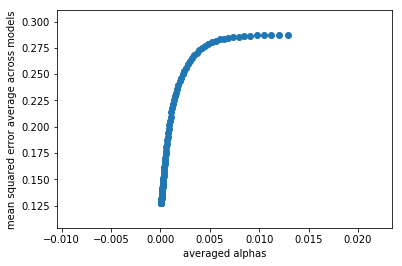

Fitted satisfaction vs actual satisfaction for training variable


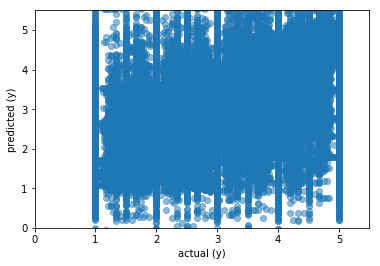

Fitted satisfaction vs actual satisfaction for test variable


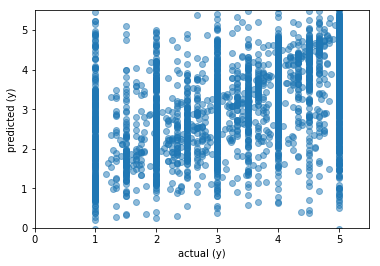

[1.3762028986159025, 1.698490261549106]

In [110]:
# final comparison between predictive approaches

# comb_res_weights
# comb_res_datweights

def metrics2 (combined_results, mse = True, alpha_vs_mse=False, true_vs_predicted=False, 
              no_outlier_plt = True, trim = True):
    
    """
    
    Get mean squared error and mean absolute errors for elastic net prediction, together with
    a graph showing a plot with elastic net shrinking factor alpha on x-axis and mean squared test 
    errors on y-axis.
    
    Inputs:
        - combined_results (dict): elastic net regression outputs from gp_elnet_pred2() function
        - mse (True/False): whether to output AN AVERAGE OF mean squared errors or mean absolute errors FOR ALL 
        TRAINED ELASTIC NET MODELS. The default is mean squared errors, with 'mse = True'.
        - cv_graph (True/False): whether to output a graph showing a plot with Lasso shrinking factor alpha 
        on x-axis and mean squared test errors on y-axis (A GLOBAL AVERAGE FOR ALL TRAINED ELASTIC NET MODELS) (optional)
        
    Outputs:
        - mean squared or mean absolute errors for the training and test datasets, average for all models
        - plot showing elastic net regression shrinking factor alpha on x-axis and 
        mean squared test errors on y-axis
        - plot showing predicted vs. actual values
    """
        
    #mean squared errors and average errors for training and test data
    
    train = pd.DataFrame(columns = ['gp_id', 'y_train', 'yhat_train'])
    test = pd.DataFrame(columns = ['gp_id', 'y_test', 'yhat_test'])
    if alpha_vs_mse == True:
        cols = ['mse' + str(x) for x in range(100)]
        cols.insert(0,'gp_id')
        tmp = ['alpha' + str(x) for x in range(100)]
        cols.extend(tmp)  
        mses_and_alphas = []
    
    for nr, key in enumerate(list(combined_results[0])): 
        if nr < 30000000000:
            # prepare data for obtaining average MSE or average MAE
            tmp = combined_results[1][key].loc[:, [1,'yhat_train']]
            tmp.columns = ['y_train', 'yhat_train']
            gp = [key for x in tmp.yhat_train]
            tmp['gp_id'] = gp
            tmp = tmp[['gp_id', 'y_train', 'yhat_train']]
            train = pd.concat([train,tmp])
            
            tmp = combined_results[2][key].loc[:, [1,'yhat_test']]
            tmp.columns = ['y_test', 'yhat_test']
            gp = [key for x in tmp.yhat_test]
            tmp['gp_id'] = gp
            tmp = tmp[['gp_id', 'y_test', 'yhat_test']]
            test = pd.concat([test,tmp])
            if alpha_vs_mse == True:
                # prepare data for alpha_vs_mse plot
                row = [np.mean(x) for x in combined_results[0][key].mse_path_]
                row.extend(combined_results[0][key].alphas_)
                row.insert(0,key)
                mses_and_alphas.append(row)
    
    
    if trim == True:
        tmp = list(test['yhat_test'])
        tmp2 = []
        for x in tmp:
            if x > 5:
                tmp2.append(5)
            elif x < 1:
                tmp2.append(1)
            else:
                tmp2.append(x)
        test['yhat_test'] = tmp2

    avg_train = 0
    avg_test = 0
    if mse == True:
        avg_train = mean_squared_error(train['y_train'],train['yhat_train'])
        avg_test = mean_squared_error(test['y_test'],test['yhat_test'])
    else:
        dif_train = train['y_train'] - train['yhat_train']
        dif_abs_train = [abs(x) for x in dif_train]
        avg_train = np.mean(dif_abs_train)
        
        dif_test = test['y_test'] - test['yhat_test']
        dif_abs_test = [abs(x) for x in dif_test]
        avg_test = np.mean(dif_abs_test)
    
    errors = [avg_train,avg_test]
    

    #average_mses vs average_alphas plot
    if alpha_vs_mse == True:
        mses_and_alphas = pd.DataFrame(mses_and_alphas, columns = cols)
        average_mses = [np.mean(mses_and_alphas.loc[:,x]) for x in list(mses_and_alphas)[1:101]]
        average_alphas = [np.mean(mses_and_alphas.loc[:,x]) for x in list(mses_and_alphas)[101:201]]

        plt.scatter(average_alphas, average_mses)
        
        plt.xlabel('averaged alphas')
        plt.ylabel('mean squared error average across models')
        plt.show()
    

    # predictions vs actual values plots
    if true_vs_predicted == True:
        print("Fitted satisfaction vs actual satisfaction for training variable")
        plt.scatter(train['y_train'], train['yhat_train'], alpha=0.5)
        plt.xlabel('actual (y)')
        plt.ylabel('predicted (y)')
        if no_outlier_plt == True:
            axes = plt.gca()
            axes.set_xlim([0,5.5])
            axes.set_ylim([0,5.5])
        plt.show()
        print("Fitted satisfaction vs actual satisfaction for test variable")
        plt.scatter(test['y_test'], test['yhat_test'], alpha=0.5)
        plt.xlabel('actual (y)')
        plt.ylabel('predicted (y)')
        if no_outlier_plt == True:
            axes = plt.gca()
            axes.set_xlim([0,5.5])
            axes.set_ylim([0,5.5])
        plt.show()

    return errors


metrics2(comb_res_weights, mse = True, alpha_vs_mse=True, 
         true_vs_predicted=True, trim = False)

In [103]:
# comb_res_weights (t = 300)
# [1.3762028986159025, 1.698490261549106]
# [1.3762028986159025, 1.4615974257281754]

# comb_res_weights (t = 1200)
# [1.2293198892787396, 1.9815286456735985]
# [1.2293198892787396, 1.6117082947294621] (trim == True)

# comb_res_datweights
# [1.4588211586086022, 2.1002286183703696]
# [1.4588211586086022, 1.5535632237217354] (trim == True)

# [elnet_mods, train_allmods, test_allmods]

# AFTER TRIM OF SURREAL PREDICTIONS

# print(len(x))
# print(x[0])
tmp = list(xxx[1]['yhat_test'])
tmp2 = []
for x in tmp:
    if x > 5:
        tmp2.append(5)
    elif x < 1:
        tmp2.append(1)
    else:
        tmp2.append(x)
xxx[1]['yhat_test'] = tmp2


[2.1064480565644867, 1, 4.916058593011228, 2.385575608148596, 2.60156239171909, 1.4298284889844286, 2.750380668532861, 2.106399843167158, 1.857504056420809, 3.569376726151565, 5, 2.7348919926534934, 5, 4.456996697023436, 4.2904940847096285, 3.378500073986413, 4.226750245106222, 1.3278990651069584, 1.982032080699792, 3.315162223798293, 1.6891840107993805, 1.8758130886978654, 3.0063618866270225, 3.6652922653429694, 4.145930323569084, 3.067161853357712, 4.594196734162379, 3.0262928345269646, 4.098957340874534, 3.7261437647579547, 2.3538477316884316, 3.908356020162282, 2.0825601431672682, 3.453994833068701, 2.848361946187824, 2.084052594118169, 2.778446856355405, 2.545809805059744, 2.4260004622434956, 1.2028193798680202, 3.5229895351651628, 2.726623827240822, 4.691403325568001, 4.082682884238679, 2.913402039330247, 5, 3.0790332525153707, 2.771608877820548, 3.017161638361103, 3.4479080824793975, 3.3652630225849802, 2.087398683255058, 3.235772590867705, 4.379589378469042, 1, 1.80152555325313

In [94]:
# comb_res_datweights[2][14142]
# comb_res_datweights[1][14142]